In [1]:
import tensorflow as tf
from PIL import Image
import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
ls

 Volume in drive Q is fun_stuff
 Volume Serial Number is DE9F-6321

 Directory of Q:\minor_project\pix2pix

09-05-2021  15:07    <DIR>          .
09-05-2021  15:07    <DIR>          ..
09-05-2021  15:03         3,118,842 .~maps_.ipynb
26-03-2021  05:31    <DIR>          .ipynb_checkpoints
26-03-2021  05:27    <DIR>          archive
09-05-2021  14:55    <DIR>          images
09-05-2021  15:07         3,119,195 maps_.ipynb
26-03-2021  08:56    <DIR>          model
               2 File(s)      6,238,037 bytes
               6 Dir(s)  19,114,680,320 bytes free


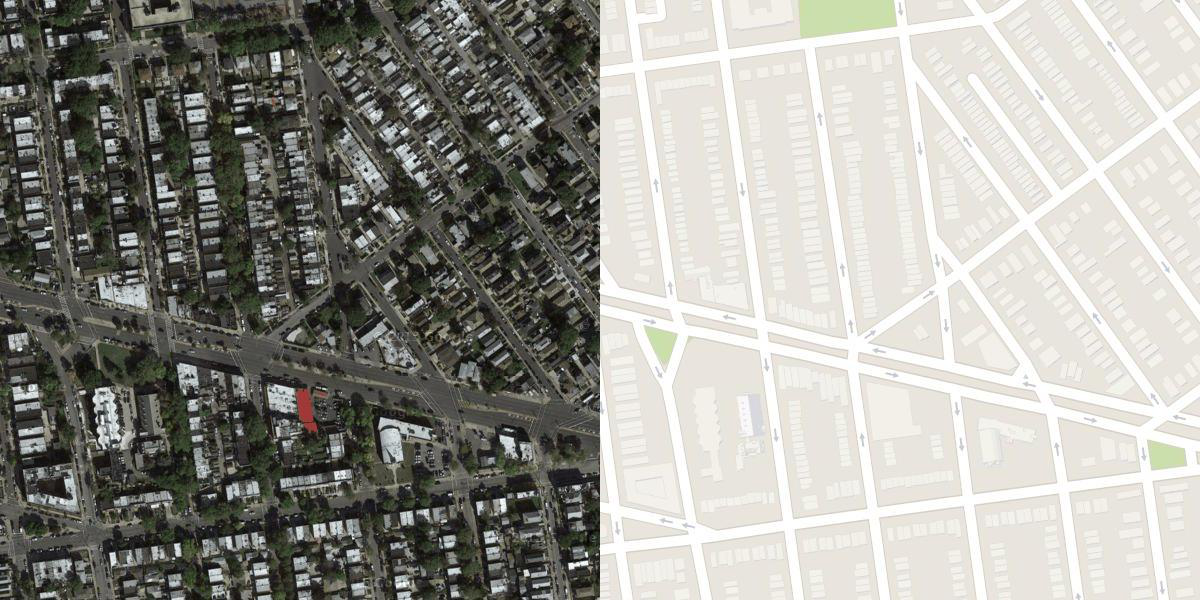

In [3]:
Image.open(r"./archive/train/1.jpg")

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 100

In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image= tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]
    
    w = w//2
    real_image = image[:,:w,:]
    input_image = image[:,w:,:]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
    stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [8]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [10]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [11]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [12]:
train_dataset = tf.data.Dataset.list_files("./archive/train/"+'*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [13]:
test_dataset = tf.data.Dataset.list_files("./archive/val/" + '*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [15]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>

In [16]:
def downsample(filters, size, apply_batchnorm= True):
    initializer = tf.random_normal_initializer(0. , 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2 , padding='same', kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [17]:
def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0. , 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Convolution2DTranspose(filters, size , strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
    )
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    return result
    

In [18]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    
    down_stack = [
        downsample(64,4,apply_batchnorm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
    ]
    
    up_stack = [
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4),
        upsample(256,4),
        upsample(128,4),
        upsample(64,4),
    ]
    
    initializer = tf.random_normal_initializer(0. , 0.02)
    last = tf.keras.layers.Convolution2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',kernel_initializer=initializer,activation='tanh')
    
    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
generator = Generator()

In [20]:
print(generator.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [21]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256,256,3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256,256,3], name='target_image')
    x = tf.keras.layers.concatenate([inp,tar])
    
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256,4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv  = tf.keras.layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [23]:
discriminator = Discriminator()

In [24]:
print(discriminator.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [166]:
def generate_images(model, test_input, tar):
    print(test_input[0].shape)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

(256, 256, 3)


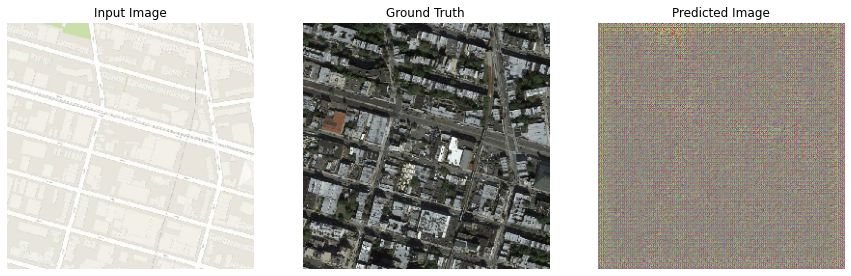

In [167]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [30]:
EPOCHS = 20

In [31]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [32]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

    # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

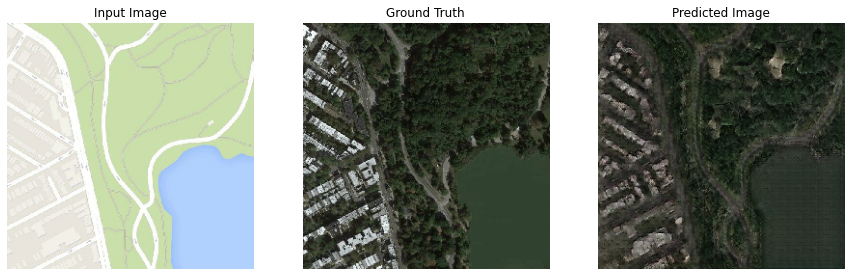

Epoch:  19
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [37]:
fit(train_dataset, EPOCHS, test_dataset)

In [38]:
generator.save('./model')

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


In [33]:
load_model = tf.keras.models.load_model('./model')

In [34]:
print(load_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

(256, 256, 3)


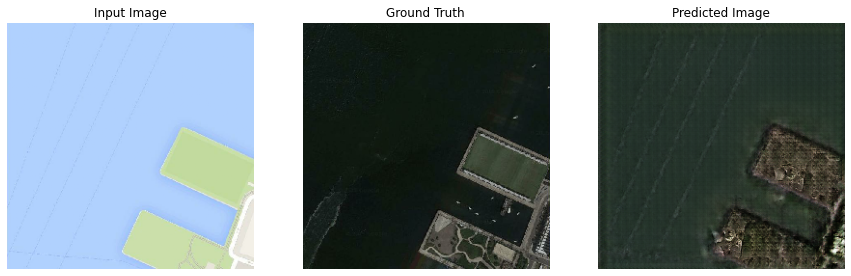

In [288]:
for example_input, example_target in test_dataset.take(1):
            generate_images(load_model, example_input, example_target)

In [327]:
ex_dataset = tf.data.Dataset.list_files("./images/" + '*.jpg')
ex_dataset = ex_dataset.map(ex_image_test)
ex_dataset = ex_dataset.batch(BATCH_SIZE)


load_ex started
here1
here2
here3
here4
load_ex completed
here1
here2
resize completed
normalize completed


In [319]:
def load_ex(image_file):
    print('here1')
    image = tf.io.read_file(image_file)
    print('here2')
    image= tf.image.decode_jpeg(image)    
    print('here3')
    input_image = tf.cast(image, tf.float32)
    print('here4')
    return input_image

In [323]:
def resize_ex(input_image, height, width):
    print('here1')
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    print('here2')
    return input_image

In [313]:
def normalize_ex(input_image):
    input_image = (input_image / 127.5) - 1  
    return input_image

In [326]:
def ex_image_test(image_file):
    print('load_ex started')
    input_image = load_ex(image_file)
    print('load_ex completed')
    input_image = resize_ex(input_image, IMG_HEIGHT, IMG_WIDTH)
    print('resize completed')
    input_image = normalize_ex(input_image)
    print('normalize completed')
    return input_image

In [329]:
ex_dataset

<BatchDataset shapes: (None, 256, 256, None), types: tf.float32>

(256, 256, 3)


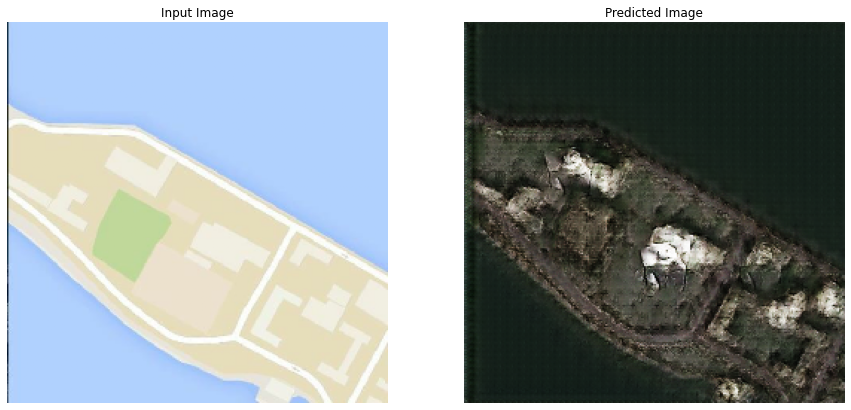

In [335]:
for example_input in ex_dataset.take(1):
            generate_images_x(load_model, example_input)

In [333]:
def generate_images_x(model, test_input):
    print(test_input[0].shape)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()